# Convolution network

This demo shows the usage of the convolution network to bind two Semantic Pointers.

In [1]:
%matplotlib inline

import nengo
import numpy as np
import matplotlib.pyplot as plt

import nengo_spa
from nengo_spa import Vocabulary

# Change the seed of this RNG to change the vocabulary
rng = np.random.RandomState(0)

## Create and run the model

Our model is going to compute the convolution (or binding) of two semantic pointers `A` and `B`. We can use the `nengo_spa.Vocabulary` class to create the two random semantic pointers, and compute their exact convolution `C = A * B`.

In [2]:
# Number of dimensions for the Semantic Pointers
dimensions = 32

vocab = Vocabulary(dimensions=dimensions, pointer_gen=rng)

# Set `C` to equal the convolution of `A` with `B`. This will be 
# our ground-truth to test the accuracy of the neural network.
vocab.populate('A; B; C=A*B')

Our network will then use neurons to compute this same convolution. We use the `nengo.networks.CircularConvolution` class, which performs circular convolution by taking the Fourier transform of both vectors, performing element-wise complex-number multiplication in the Fourier domain, and finally taking the inverse Fourier transform to get the result.

In [3]:
model = nengo.Network(seed=1)
with model:
    # Get the raw vectors for the pointers using `vocab['A'].v`
    a = nengo.Node(output=vocab['A'].v)
    b = nengo.Node(output=vocab['B'].v)
    
    # Make the circular convolution network with 200 neurons
    cconv = nengo.networks.CircularConvolution(200, dimensions=dimensions)
    
    # Connect the input nodes to the input slots `A` and `B` on the network
    nengo.Connection(a, cconv.input_a)
    nengo.Connection(b, cconv.input_b)
    
    # Probe the output
    out = nengo.Probe(cconv.output, synapse=0.03)

In [4]:
with nengo.Simulator(model) as sim:
    sim.run(1.)

## Analyze the results

We plot the dot product between the exact convolution of `A` and `B` (given by `C = A * B`), and the result of the neural convolution (given by `sim.data[out]`).

The dot product is a common measure of similarity between semantic pointers, since it approximates the cosine similarity when the semantic pointer lengths are close to one. The cosine similarity is a common similarity measure for vectors; it is simply the cosine of the angle between the vectors.

Both the dot product and the exact cosine similarity can be computed with `nengo_spa.similarity`. Normally, this function will compute the dot products between each data vector and each vocabulary vector, but setting `normalize=True` normalizes all vectors so that the exact cosine similarity is computed instead.

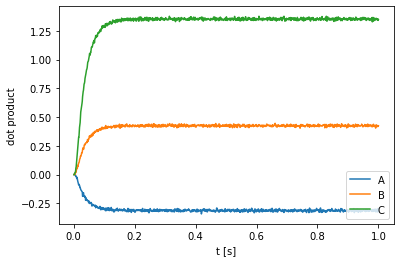

In [5]:
plt.plot(sim.trange(), nengo_spa.similarity(sim.data[out], vocab))
plt.legend(list(vocab.keys()), loc=4)
plt.xlabel("t [s]")
plt.ylabel("dot product");

The above plot shows that the neural output is much closer to `C = A * B` than to either `A` or `B`, suggesting that our network is correctly computing the convolution. It also highlights an important property of circular convolution: The circular convolution of two vectors is dissimilar to both of the vectors.

The dot product between the neural output and `C` is not exactly one due in large part to the fact that the length of `C` is not exactly one (see below). To actually measure the cosine similarity between the vectors (that is, the cosine of the angle between the vectors), we have to divide the dot product by the lengths of both `C` and the neural output vector approximating `C`.

In [6]:
# The length of `C` is not exactly one
print(vocab['C'].length())

1.2268492050048845


Performing this normalization, we can see that the cosine similarity between the neural output vectors and `C` is almost exactly one, demonstrating that the neural population is quite accurate in computing the convolution.

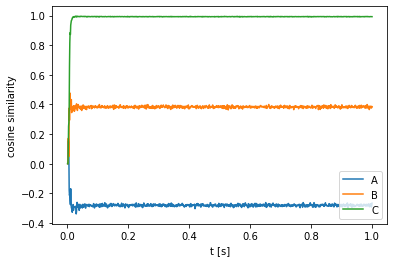

In [7]:
plt.plot(sim.trange(), nengo_spa.similarity(
    sim.data[out], vocab, normalize=True))
plt.legend(list(vocab.keys()), loc=4)
plt.xlabel("t [s]")
plt.ylabel("cosine similarity");